# Jupyter Lectures, First Year Project 2021

## Project 1 - Road collisions analysis, ITU Copenhagen

**Instructor: Michael Szell**

Course page: https://learnit.itu.dk/local/coursebase/view.php?ciid=590

This notebook contains all the code developed in the course lectures to wrangle and explore the data set from the project.

Contact: Michael Szell (misz@itu.dk)  
Created: 2021-01-29  
Last modified: 2021-01-29

<hr>

# Lecture 1: First data exploration

### Imports

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.stats import chi2_contingency

%run -i ../scripts/functions.py



Loaded functions.



### Constants

Constants are written all caps: https://www.python.org/dev/peps/pep-0008/#constants

In [2]:
PATH = {
    'raw': Path('../data/raw/'),
    'processed': Path('../data/processed/'),
    'interim': Path('../data/interim/'),
    'references': Path('../references')
}

#DATA paths
PATH['accident'] = PATH['interim'] / "bradford_accidents.csv"
PATH['casual'] = PATH['interim'] / "bradford_casualties.csv"
PATH['vehicles'] = PATH['interim'] / "bradford_vehicles.csv"

#Other paths
PATH['var_lookup'] = PATH['references'] / 'variable lookup.xls'

We would like to use the labels from the excel file. These are loaded below in a dict of dataframes.

Then we are able to lookup the field's labels very easially for the categorical values

In [181]:
# sheet_name=none gives all sheets 
EXCEL_LABELS = pd.read_excel(PATH['var_lookup'], sheet_name = None, index_col = 0)
FLD_LOOKUP = {}

# maps special sheet name to full name for later proccesing
special_sheet_names = {'Ped_Location': 'Pedestrian_Location', \
                  'Ped_Movement': 'Pedestrian_Movement',
                      'Speed_Limit': 'Speed_limit'}

for sheet_name in EXCEL_LABELS:
    # add underscores in field name since its missing in excel
    fixed_sheet_name = sheet_name.replace(" ", "_")
    
    # handle sheet names that are significally different named compared to the table headers
    if fixed_sheet_name in special_sheet_names:
        fixed_sheet_name = special_sheet_names[fixed_sheet_name]
    
    # create new dict with renamed keys
    FLD_LOOKUP[fixed_sheet_name] = EXCEL_LABELS[sheet_name]


# interesting function to create "Categorical" objects
# Todo: maybe 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.from_codes.html#pandas.Categorical.from_codes
#pd.Categorical.from_codes(VAR_LOOKUP.)

### Load raw data

The data were downloaded from here on Jan 4th: https://data.gov.uk/dataset/road-accidents-safety-data  
That page was updated afterwards (Jan 8th), so local and online data may be inconsistent.

How are missing values handled?  
According to the datasheet for the dataset, "-1" means "not avaliable", so we handle these values as such using a Panda DataFrame

In [4]:
# Dict to store our data
DATA = {}

# Read data and explicitly define some data types for columns
DATA['accident'] = pd.read_csv(PATH['accident'], dtype={0: 'string', 31: 'string'}, encoding='utf-8-sig', na_values="-1")

DATA['casual'] = pd.read_csv(PATH['casual'], dtype={0: 'string'}, encoding='utf-8-sig', na_values="-1")

DATA['vehicles'] = pd.read_csv(PATH['vehicles'], dtype={0: 'string'}, encoding='utf-8-sig', na_values="-1") # Maybe useful later: add index_col=0

In [148]:

PATH['accidentTEST'] = PATH['raw'] / "Road Safety Data - Accidents 2019.csv"
DATA['accidentTEST'] = pd.read_csv(PATH['accidentTEST'] , dtype={0: 'string', 31: 'string'}, encoding='utf-8-sig', na_values="-1")
DATA['accidentTEST'] 

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,...,0.0,5.0,1.0,1,1.0,0.0,0.0,1,3,E01004762
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,15/01/2019,...,NaN,NaN,4.0,1,1.0,0.0,0.0,1,3,E01003117
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,01/01/2019,...,0.0,0.0,4.0,1,1.0,0.0,0.0,1,1,E01000943
3,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,01/01/2019,...,0.0,0.0,4.0,1,1.0,0.0,0.0,1,1,E01000973
4,2019010155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,01/01/2019,...,0.0,0.0,4.0,1,1.0,0.0,0.0,1,1,E01000546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117531,2019984106919,312635.0,573392.0,-3.368899,55.047323,98,3,1,1,18/05/2019,...,0.0,0.0,1.0,1,2.0,0.0,0.0,2,1,<NA>
117532,2019984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,30/05/2019,...,0.0,0.0,1.0,1,2.0,0.0,0.0,2,1,<NA>
117533,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,21/06/2019,...,0.0,0.0,1.0,1,1.0,0.0,0.0,2,2,<NA>
117534,2019984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,1,29/06/2019,...,0.0,0.0,1.0,1,1.0,0.0,0.0,2,2,<NA>


We first explore one data table, the accidents.

In [5]:
pd.unique(DATA['accident']['Special_Conditions_at_Site'])

array([0, 3, 1, 7, 4, 5])

In [6]:
HEADERS = {
    'accident': DATA['accident'].columns,
    'casual': DATA['casual'].columns,
    'vehicles': DATA['vehicles'].columns
}

HEADERS['accident']

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

It is always good to start with a "sneak preview":

In [7]:
DATA['accident'][:5]

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019136111019,417000.0,433017.0,-1.743423,53.793206,13,3,2,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01010606
1,2019136111467,419018.0,433809.0,-1.712742,53.800255,13,3,3,2,02/01/2019,...,0,0,1,1,1,0,0,1,1,E01010618
2,2019136121066,418157.0,430906.0,-1.725984,53.774194,13,3,2,1,02/01/2019,...,0,0,1,1,1,0,0,1,1,E01010615
3,2019136131015,415321.0,438238.0,-1.768652,53.840183,13,3,2,2,03/01/2019,...,0,5,1,1,1,0,0,1,1,E01010571
4,2019136131184,415008.0,431561.0,-1.773732,53.780180,13,3,1,1,03/01/2019,...,0,0,1,1,1,0,0,1,2,E01010735


In [8]:
DATA['casual'][:5]

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2019136111019,2,1,1,1,56,9,3,0,0,0,0,0,9,1.0,1.0
1,2019136111467,2,1,1,1,50,8,3,0,0,0,0,0,9,1.0,1.0
2,2019136111467,2,2,2,2,46,8,3,0,0,1,0,0,9,1.0,1.0
3,2019136121066,2,1,1,1,20,4,3,0,0,0,0,0,19,1.0,1.0
4,2019136131015,1,1,1,2,52,8,3,0,0,0,0,0,9,1.0,10.0


Reminder and documentation on structured arrays:  
https://numpy.org/devdocs/user/basics.rec.html

#### Insight: Mixed variable types

Number of records

In [9]:
DATA['accident'].shape

(833, 32)

Number of fields

In [10]:
len(DATA['accident'].dtypes), len(DATA['vehicles'].dtypes), len(DATA['casual'].dtypes)


(32, 23, 16)

**"Data in the wild" puzzle: Why is the first field "\ufeffAccident_Index" and not "Accident_Index"?**

Fields

In [11]:
DATA['vehicles'].dtypes

Accident_Index                       string
Vehicle_Reference                     int64
Vehicle_Type                          int64
Towing_and_Articulation               int64
Vehicle_Manoeuvre                     int64
Vehicle_Location-Restricted_Lane      int64
Junction_Location                     int64
Skidding_and_Overturning              int64
Hit_Object_in_Carriageway             int64
Vehicle_Leaving_Carriageway           int64
Hit_Object_off_Carriageway            int64
1st_Point_of_Impact                   int64
Was_Vehicle_Left_Hand_Drive?          int64
Journey_Purpose_of_Driver             int64
Sex_of_Driver                         int64
Age_of_Driver                       float64
Age_Band_of_Driver                  float64
Engine_Capacity_(CC)                float64
Propulsion_Code                     float64
Age_of_Vehicle                      float64
Driver_IMD_Decile                   float64
Driver_Home_Area_Type               float64
Vehicle_IMD_Decile              

<hr>

We explore the other two tables the same way.

In [12]:
DATA['vehicles'].dtypes

Accident_Index                       string
Vehicle_Reference                     int64
Vehicle_Type                          int64
Towing_and_Articulation               int64
Vehicle_Manoeuvre                     int64
Vehicle_Location-Restricted_Lane      int64
Junction_Location                     int64
Skidding_and_Overturning              int64
Hit_Object_in_Carriageway             int64
Vehicle_Leaving_Carriageway           int64
Hit_Object_off_Carriageway            int64
1st_Point_of_Impact                   int64
Was_Vehicle_Left_Hand_Drive?          int64
Journey_Purpose_of_Driver             int64
Sex_of_Driver                         int64
Age_of_Driver                       float64
Age_Band_of_Driver                  float64
Engine_Capacity_(CC)                float64
Propulsion_Code                     float64
Age_of_Vehicle                      float64
Driver_IMD_Decile                   float64
Driver_Home_Area_Type               float64
Vehicle_IMD_Decile              

In [13]:
DATA['casual'].dtypes

Accident_Index                         string
Vehicle_Reference                       int64
Casualty_Reference                      int64
Casualty_Class                          int64
Sex_of_Casualty                         int64
Age_of_Casualty                         int64
Age_Band_of_Casualty                    int64
Casualty_Severity                       int64
Pedestrian_Location                     int64
Pedestrian_Movement                     int64
Car_Passenger                           int64
Bus_or_Coach_Passenger                  int64
Pedestrian_Road_Maintenance_Worker      int64
Casualty_Type                           int64
Casualty_Home_Area_Type               float64
Casualty_IMD_Decile                   float64
dtype: object

## Index checking for the 3 data sets
Our dataset contains an indexed column named "accident_index" for each of the 3 tables. We do some sanity checks for this index.

### Check if DATA['vehicles'] accident index column maps to an accident_index in DATA['accidents]

A= accident  
B= vehicles

So we get all the vehicle records that does not connect to accident_records

<img src="../references/right_excluding_join.png" alt="source: http://www.codeproject.com/KB/database/Visual_SQL_Joins/RIGHT_EXCLUDING_JOIN.png">




In [14]:
# https://stackoverflow.com/questions/53645882/pandas-merging-101
DATA['accident_r_exc_join'] = DATA['accident'].merge(DATA['vehicles'], on='Accident_Index', how='right', indicator=True)\
    .query('_merge == "right_only"').drop('_merge', 1)

print("in accident right excluding joined with vehicles there is", DATA['accident_r_exc_join'].shape[0], "vehicle-records which does not have a related accident information")

in accident right excluding joined with vehicles there is 0 vehicle-records which does not have a related accident information


Conclusion: all the accident_indexes in the vechicle records seems correct

### Check if DATA['casualties'] accident index column maps to an accident_index in DATA['accidents]

A= accident  
B= casualties

So we get all the casualties records that does not connect to accident_records

<img src="../references/right_excluding_join.png" alt="source: http://www.codeproject.com/KB/database/Visual_SQL_Joins/RIGHT_EXCLUDING_JOIN.png">




In [15]:
DATA['accident_r_exc_join'] = DATA['accident'].merge(DATA['casual'], on='Accident_Index', how='right', indicator=True)\
    .query('_merge == "right_only"').drop('_merge', 1)

print("in accident right excluding joined with casualties there is", DATA['accident_r_exc_join'].shape[0], "casualty-records which does not have a related accident information")

in accident right excluding joined with casualties there is 0 casualty-records which does not have a related accident information


Conclusion: all the accident_indexes in the casualty records seems correct

# Lecture 2: Command line wrangling and dealing with missing data

A faster way of getting basic insights into a new data set than by using numpy is by using command line tools.

Let's get a first overview using `head`. There are 3 data tables: Accidents, Casualties, and Vehicles.

In [16]:
!head -n 5 "../data/interim/bradford_accidents.csv"

Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
2019136111019,417000.0,433017.0,-1.743423,53.793206,13,3,2,1,01/01/2019,3,08:00,200,E08000032,3,650,6,30,6,4,3,647,0,0,4,1,1,0,0,1,1,E01010606
2019136111467,419018.0,433809.0,-1.712742,53.800255,13,3,3,2,02/01/2019,4,13:20,200,E08000032,6,0,6,30,0,-1,-1,0,0,0,1,1,1,0,0,1,1,E01010618
2019136121066,418157.0,430906.0,-1.725984,53.774194,13,3,2,1,02/01/2019,4,15:45,200,E08000032,3,650,3,4

### General insights

#### Link between data tables

Records between data tables are linked through their `Accident_Index`.

Looking at the first Accident_Index 2019010128300, we can see there seems to be a one-to-many relation between accident->casualty and accident->vehicle, meaning there can be multiple casualties and vehicles involved in one accident (makes sense).

https://en.wikipedia.org/wiki/One-to-many_(data_model)

#### Dimensions

Number of records

https://en.wikipedia.org/wiki/Wc_(Unix)

In [17]:
!wc -l "../data/interim/bradford_accidents.csv"

834 ../data/interim/bradford_accidents.csv


Number of fields (in first line)

https://www.geeksforgeeks.org/awk-command-unixlinux-examples/

In [18]:
!head -n 1 "../data/interim/bradford_accidents.csv" | awk -F "," "{print NF}"

32


See and count all fields

https://en.wikipedia.org/wiki/Tr_(Unix)
https://en.wikipedia.org/wiki/Nl_(Unix)

In [19]:
!head -n 1 "../data/interim/bradford_accidents.csv" | tr "," "\n" | nl

     1	Accident_Index
     2	Location_Easting_OSGR
     3	Location_Northing_OSGR
     4	Longitude
     5	Latitude
     6	Police_Force
     7	Accident_Severity
     8	Number_of_Vehicles
     9	Number_of_Casualties
    10	Date
    11	Day_of_Week
    12	Time
    13	Local_Authority_(District)
    14	Local_Authority_(Highway)
    15	1st_Road_Class
    16	1st_Road_Number
    17	Road_Type
    18	Speed_limit
    19	Junction_Detail
    20	Junction_Control
    21	2nd_Road_Class
    22	2nd_Road_Number
    23	Pedestrian_Crossing-Human_Control
    24	Pedestrian_Crossing-Physical_Facilities
    25	Light_Conditions
    26	Weather_Conditions
    27	Road_Surface_Conditions
    28	Special_Conditions_at_Site
    29	Carriageway_Hazards
    30	Urban_or_Rural_Area
    31	Did_Police_Officer_Attend_Scene_of_Accident
    32	LSOA_of_Accident_Location


### Sanity checks

Has each record the same number of fields?

https://shapeshed.com/unix-uniq/  
https://www.putorius.net/uniq-command-linux.html

In [20]:
!awk -F "," "{print NF}" "../data/interim/bradford_accidents.csv" | sort | uniq -d

32


How many duplicate lines are there? (If more than 0, there could be a problem)

In [21]:
!sort "../data/interim/bradford_accidents.csv" | uniq -d | wc -l

0


More advanced stuff with `awk`: https://datafix.com.au/BASHing/2020-05-20.html

## Dealing with missing data

Using a masked array:  
https://numpy.org/devdocs/reference/maskedarray.baseclass.html#numpy.ma.MaskedArray

In [22]:
DATA['accident'][:5].isnull()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


How many values in total?  
Which fields are missing?

In [23]:
# DATA['accident'].isnull().sum(), "--- sum ---", DATA['accident'].isnull().sum().sum()

# Pandas: first sum the missing values row-wise, then sum all the row-wise sums to one single sum
# Missing                            Not missing
DATA['accident'].isna().sum().sum(), DATA['accident'].notna().sum().sum()

(685, 25971)

Summary of missing values:

In [24]:
# Overview of missing values in columns
DATA['accident'].isna().any()

# Get only the names of the columns with missing values
DATA['accident'].columns[DATA['accident'].isna().any()]

# Return the rows with missing values
DATA['accident'][DATA['accident'].isna().any(axis=1)]['Time']

1      13:20
4      08:05
5      17:22
6      14:35
8      17:15
       ...  
821    17:15
825    13:42
826    17:45
827    23:45
830    12:18
Name: Time, Length: 343, dtype: object

## Task 1 - Frequency of road collisions in your city for...

### a) ...different age groups

In [25]:
# Age analysis
DATA['casual']['Age_Band_of_Casualty'].value_counts()

6     176
7     170
4     161
8     149
5     141
9      85
3      75
10     49
2      42
1      37
11     32
Name: Age_Band_of_Casualty, dtype: int64

### b) ...in different times
(during the day, the week, or year)

In [26]:
# Time analysis
DATA['accident']['Day_of_Week'].value_counts()

5    139
4    135
6    129
3    122
2    111
7    109
1     88
Name: Day_of_Week, dtype: int64

### c) ...and for differences in one other condition.

In [27]:
# Movement analysis - Task 1, c
DATA['casual']['Pedestrian_Movement'].value_counts()

0    873
1     98
3     50
9     45
2     20
4     13
5      9
7      5
6      3
8      1
Name: Pedestrian_Movement, dtype: int64

<hr>

# Lecture 3: Visual data exploration, Connecting tables, Association test

## Visual exploratory data analysis ("Plot your data")

### Bar plots of categorical variables

In [28]:
HEADERS['accident']

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [29]:
DATA['accident']['Day_of_Week'][:4]

0    3
1    4
2    4
3    5
Name: Day_of_Week, dtype: int64

We were lucky because the categories 1,2,3 were "nice". But usually they aren't, so we need to explicitly map to integers:

Instead of copy-pasting code, let's write a function.

Typing the variable lookup manually is cumbersome. Can we read the excel directly?  
pandas can: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

### Histograms of numerical variables

### Categorical scatterplots

Scatterplots are good for relating two numerical variables. If we have one numerical versus one categorical variable, we can do a box plot. But could we also visualize all data points? Yes: https://seaborn.pydata.org/tutorial/categorical.html

## Connecting tables with np.isin()

**Question: How many babies and toddlers died on UK roads in June 2019?**

Numpy has the fucntion isin() to select for a list of indices: https://numpy.org/doc/stable/reference/generated/numpy.isin.html

**Question: Who killed them?**

Homework

## Association test between two categorical variables 
**(Pearson $\chi^2$ test of independence)**

Inspired by:  
https://peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomNom/NomNom-2a-Test.html  
https://bit.ly/3kbwKEL

**Let us ask: Is there a statistically significant association between accident severity and speed limit?**  
We ask because speed limit is something that the city government can regulate.

### Hypothesis testing

We are now in the realm of [Statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). In general, we must first state and compare two hypotheses:

- $H_0$ (null hypothesis): There is no statistically significant relationship between accident severity and speed limit.
- $H_\alpha$ (alternative hypothesis): There is a statistically significant relationship between accident severity and speed limit.

We must then 1) state+check statistical assumptions, 2) choose an appropriate test and test statistic $T$, 3) derive the distribution for the test statistic, 4) select a significance level $\alpha$, usually 0.01 or 0.05, 5) calculate the observed test statistic $t_{\mathrm obs}$, 6) calculate the [p-value](https://en.wikipedia.org/wiki/P-value). 

If the p-value $< \alpha$, then the null hypothesis will be rejected.

### Pearson $\chi^2$ test of independence

To test association between two categorical variables, one uses the [Pearson chi-square test of independence](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test). If the significance of this test (p-value) is below a significance level (typically 0.05), the two variables have a significant association.

The Pearson chi-square test should only be used if most cells have an expected count above 5, and the minimum expected count is at least 1.

We crosstabulate using pandas:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html

The cross tabulation is also known as contingency table.

The idea is now to compare these observed values with expected values.  
The expected values can be calculated using:
\begin{equation*}
E_{i,j} = \frac{R_i \times C_j}{N}
\end{equation*}
The $E_{i,j}$ indicates the expected count in row i, column j. The $R_i$ is the row total of row i, and $C_j$ the column total of column j. The $N$ is the grand total.

That was the manual way of doing it. `chi2_contingency()` can do it for us automatically:

We now know that the association is significant, but how strong is it?  
Cramer's V, for example, can give an answer: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

The formula is:
\begin{equation*}
V=\sqrt{\frac{\chi^{2} / N}{\min (c-1, r-1)}}
\end{equation*}
where $c$ is the number of columns, $r$ is the number of rows.

Let us visualize this and make a human-readable plot and report below.

**Conclusion**

What about statistical tests for different combinations of numerical/categorical variables?
<img src="../references/flowchart-for-choosing-a-statistical-test.png" width="600px"/>

<hr>

## Excercise 03

- Check that all Number_of_Vehicles and Number_of_Casualties values in the accidents table are correct, by counting all the corresponding records in the vehicles and casualties tables.


In [30]:
'''for each accident_index in accidents_data
    store acc_vehi = Number_of_Vehicles involved in accident
    store acc_casult = Number_of_Casualties involved in accident
    store vechi_index_count and count how many times accident_index appear in vechicles
    store casual_index_count and count how many times accident_index appear in casualties

    if acc_vehi != vechi_index_count:
        store anomaly
    
    if acc_casult != casual_index_count:
        store anaomly

report summary'''

'for each accident_index in accidents_data\n    store acc_vehi = Number_of_Vehicles involved in accident\n    store acc_casult = Number_of_Casualties involved in accident\n    store vechi_index_count and count how many times accident_index appear in vechicles\n    store casual_index_count and count how many times accident_index appear in casualties\n\n    if acc_vehi != vechi_index_count:\n        store anomaly\n    \n    if acc_casult != casual_index_count:\n        store anaomly\n\nreport summary'

- Try out categorical scatterplots to explore combinations of numerical and categorical variables (and possible a third categorical variable for hue), where this makes sense.

In [31]:
# Filter
casualty_type_pedestrian = DATA['casual']["Casualty_Type"] == 0
casualty_type_cyclist = DATA['casual']["Casualty_Type"] == 1
casualty_type_car = DATA['casual']["Casualty_Type"] == 9
no_unkown_age = DATA["casual"]["Age_of_Casualty"] > -1

mask = (casualty_type_pedestrian | casualty_type_cyclist | casualty_type_car) & (no_unkown_age)
mask[600:] = False # Restrict to at most 600 points. should be removed at some point!


/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


,Casualty_Type,Age_of_Casualty
0,9,56
1,9,50
2,9,46
4,9,52
5,9,38
...,...,...
595,9,55
596,9,27
597,9,51
598,9,54


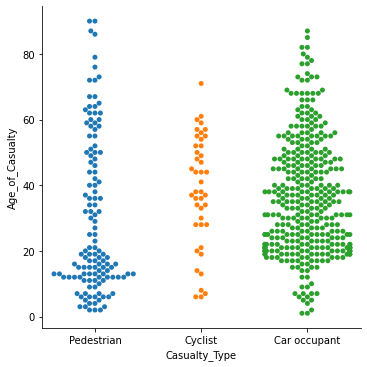

In [32]:
cat_data_1 = DATA["casual"]["Casualty_Type"][mask]
cat_data_2 = DATA["casual"]["Age_of_Casualty"][mask]

# Concaternate the data using columns (axis1)
con_cat_data = pd.concat([cat_data_1, cat_data_2], axis=1)

# Plot
fig = sns.catplot(x = 'Casualty_Type', y = 'Age_of_Casualty', data=con_cat_data, kind = "swarm") # also show: violin

fig.set_xticklabels(["Pedestrian", "Cyclist", "Car occupant"]);

con_cat_data


### Accident severity distrubution

[Text(0, 0, 'Fatal'), Text(1, 0, 'Serious'), Text(2, 0, 'Slight')]

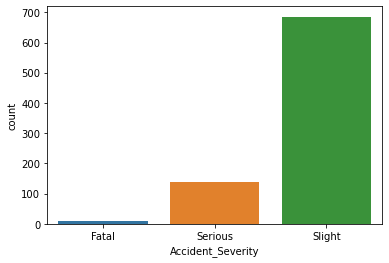

In [33]:
plots = {}
plots[1] = sns.countplot(x='Accident_Severity', data=DATA['accident'])
plots[1].set_xticklabels(FLD_LOOKUP['Accident_Severity']['label'])

### one numerical versus one categorical variable:

Scatterplot of vehicle age vs accident sevirity

eg accident number 434 had 2 vehicles involved. the mean age of the vechile is 20 years, and the accident severity is FATAL 


In [34]:
#problem: -1 is a legal age of vehcile. -1 means N/A
# now solved by loading data with specified NA values
pd.unique(DATA['vehicles']['Age_of_Vehicle'])

array([nan, 12., 16.,  8.,  1.,  9., 10.,  2., 11.,  5.,  7., 14., 13.,
        4., 15., 18.,  3.,  6., 35., 21., 17., 19., 20., 30., 22., 24.])

In [35]:
#x_data = DATA['vehicles']['Age_of_Vehicle']
#y_data = DATA['accident']['Accident_Severity']
# we are only interested in the accidents where we both have vheicles and accident information, so inner join.
# validate : “one_to_one” or “1:1”: check if merge keys are unique in both left and right datasets.
DATA['vehi_acc_inner'] = pd.merge(DATA['accident'], DATA['vehicles'], on='Accident_Index', how='inner', validate="one_to_many")

print("DATA['vehi_acc_inner'].shape", DATA['vehi_acc_inner'].shape, "DATA['vehicles'].shape", DATA['vehicles'].shape, "DATA['accident'].shape", DATA['accident'].shape, sep="\n")


DATA['vehi_acc_inner'].shape
(1451, 54)
DATA['vehicles'].shape
(1451, 23)
DATA['accident'].shape
(833, 32)


In [36]:
#problem: we need the average age of vehcicles, in case there is more vehciles per accident, so we only get 1 row = 1 accident
# solution: groupy by accident index and calcualte the mean value of vehcicle age involved in accident
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
data_analysis = {}
data_analysis['1'] = DATA['vehi_acc_inner'].groupby('Accident_Index').mean(numeric_only=True)

Lets make sure that we dont have any duplicate acc rows left, and that the grouping worked by checking for unique items:

In [37]:
# get how many unique accident indexs there is
len(pd.unique(data_analysis['1'].index))

833

same amount of rows, we assume the joining and grouping went well. we now try to plot this.
one row= one obeservation

### Car age vs accident severity

there might be more than one vehicle involved in an accident, so we take the mean age of the vehicles

/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


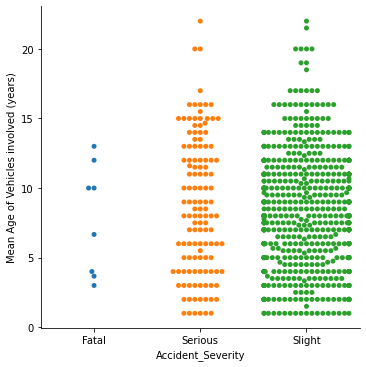

In [38]:
# use swarm to prevent points overlapping
fig = sns.catplot(x='Accident_Severity', y='Age_of_Vehicle', data=data_analysis['1'], kind="swarm")
fig.set_axis_labels("Accident_Severity", "Mean Age of Vehicles involved (years)")
fig.set_xticklabels(FLD_LOOKUP['Accident_Severity']['label'])

### categorical variable vs categorical variable
Accident Severity vs Special_Conditions_at_Site

In [48]:
def get_unique_label_fld_lookup(data=None, colname=None):
    '''Returns a DataFrame with only the labels needed to set xticklabels
    When settting xticklabels, we often have more labels in FLD_LOOKUP than present in our dataset.
    in a way, this function creates a copy of FLD_LOOKUP with only the labels used in our data (bradford)
    
    :param dataset: A Pandas DataFrame, eg DATA['accident']
    :param column: Column name as string, with underscores
    '''
    # problem: not all labels are used in 'Special Conditions at Site'
    # solution: remove the labelse not present from FLD_LOOKUP['Special Conditions at Site']
    # used_label_codes = pd.unique(DATA['accident']['Special_Conditions_at_Site'])
    used_label_codes = pd.unique(data[colname])

    # Save all labels for this column.
    all_labels = FLD_LOOKUP[colname]

    # set default values of the relevant labels we want to keep
    unique_label_fld_lookup = all_labels

    # loop through all label codes (they are set as the index)
    for label_code in all_labels.index:
        if label_code not in used_label_codes:
            # if the label is not used 
            unique_label_fld_lookup.drop(index=label_code, inplace=True)

    return unique_label_fld_lookup

In [49]:
FLD_LOOKUP['Special_Conditions_at_Site']

,label
code,
0,None
1,Auto traffic signal - out
2,Auto signal part defective
3,Road sign or marking defective or obscured
4,Roadworks
5,Road surface defective
6,Oil or diesel
7,Mud
-1,Data missing or out of range


In [50]:
FLD_LOOKUP['Special_Conditions_at_Site']

,label
code,
0,None
1,Auto traffic signal - out
2,Auto signal part defective
3,Road sign or marking defective or obscured
4,Roadworks
5,Road surface defective
6,Oil or diesel
7,Mud
-1,Data missing or out of range


Problem: how do we know which order to label in?  

Answer from seaborn: Unlike with numerical data, it is not always obvious how to order the levels of the categorical variable along its axis. In general, the seaborn categorical plotting functions try to infer the order of categories from the data. If your data have a pandas Categorical datatype, then the default order of the categories can be set there. If the variable passed to the categorical axis looks numerical, the levels will be sorted. But the data are still treated as categorical and drawn at ordinal positions on the categorical axes (specifically, at 0, 1, …) even when numbers are used to label them:

In [51]:
FLD_LOOKUP['Special Conditions at Site']['label']

KeyError: 'Special Conditions at Site'

In [ ]:
 pd.unique(DATA['accident']['Special_Conditions_at_Site'])

Problem: sns creates its own index on y axis  
solution: specify Categorical data type for each col we use

In [ ]:
# copy=false change all DATA['accident'] objects 
DATA['accident']['Accident_Severity'].astype(dtype="category", copy=False)
DATA['accident']['Special_Conditions_at_Site'].astype(dtype="category", copy=False)

### Accident Severity vs Special_Conditions_at_Site

In [ ]:
plt[2] = sns.catplot(x='Accident_Severity', y='Special_Conditions_at_Site', data=DATA['accident'])

x_labels = FLD_LOOKUP['Accident Severity']['label'].astype(dtype="category", copy=False)

plt2labels = plt[2].set_xticklabels(x_labels)
#print(plt2labels)

y_labels = pd.Categorical.from_codes(codes=FLD_LOOKUP['Special Conditions at Site'].index, categories=FLD_LOOKUP['Special Conditions at Site']['label'])

#y_labels = get_unique_label_fld_lookup(dataset=DATA['accident'], colname='Special_Conditions_at_Site')
#y_labels
#plt[2].set_yticklabels(y_labels)

## Association test between two categorical variables 


In [81]:
# RELEVANT FIELDS TO OUR RESEARCH QUESTION FROM ACCIDENT TABLE
# CATAGORICAL FIELDS:
rvl_fields_acci_cat = ['Accident_Severity', \
                       'Number_of_Casualties', \
                      '1st_Road_Class', \
                      '1st_Road_Number', \
                      'Road_Type', \
                      'Speed_limit', \
                      'Junction_Detail', \
                      'Junction_Control', \
                      '2nd_Road_Class', \
                      '2nd_Road_Number', \
                      'Pedestrian_Crossing-Human_Control', \
                      'Pedestrian_Crossing-Physical_Facilities', \
                      'Road_Surface_Conditions', \
                     'Special_Conditions_at_Site',
                      'Urban_or_Rural_Area',\
                     ]
# NUMBERICAL FIELDS:
rvl_fields_acci_num = ['Number_of_Vehicles']


# RELEVANT FIELDS TO OUR RESEARCH QUESTION FROM CASUALTIES TABLE
# CATEGORICAL FIELDS:
rvl_fields_casu_cat = ['Casualty_Severity', \
                       'Pedestrian_Location', \
                       'Pedestrian_Movement', \
]

var1 = rvl_fields_acci_cat[4] # Road_Type
var2 = rvl_fields_casu_cat[0] # 'Casualty_Severity'

In [83]:
FLD_LOOKUP[var1]

,label
code,
1,Roundabout
2,One way street
3,Dual carriageway
6,Single carriageway
7,Slip road
9,Unknown


The Pearson chi-square test should only be used if most cells have an expected count above 5, and the minimum expected count is at least 1. we check that.  

-we need to plot barplot for each variable. where x axis is the category, and y axis is count

nfields_cat 14
nfields_cat 13
nfields_cat 12
nfields_cat 11
nfields_cat 10
nfields_cat 9
nfields_cat 8
nfields_cat 7
nfields_cat 6
nfields_cat 5
nfields_cat 4
nfields_cat 3
nfields_cat 2
nfields_cat 1


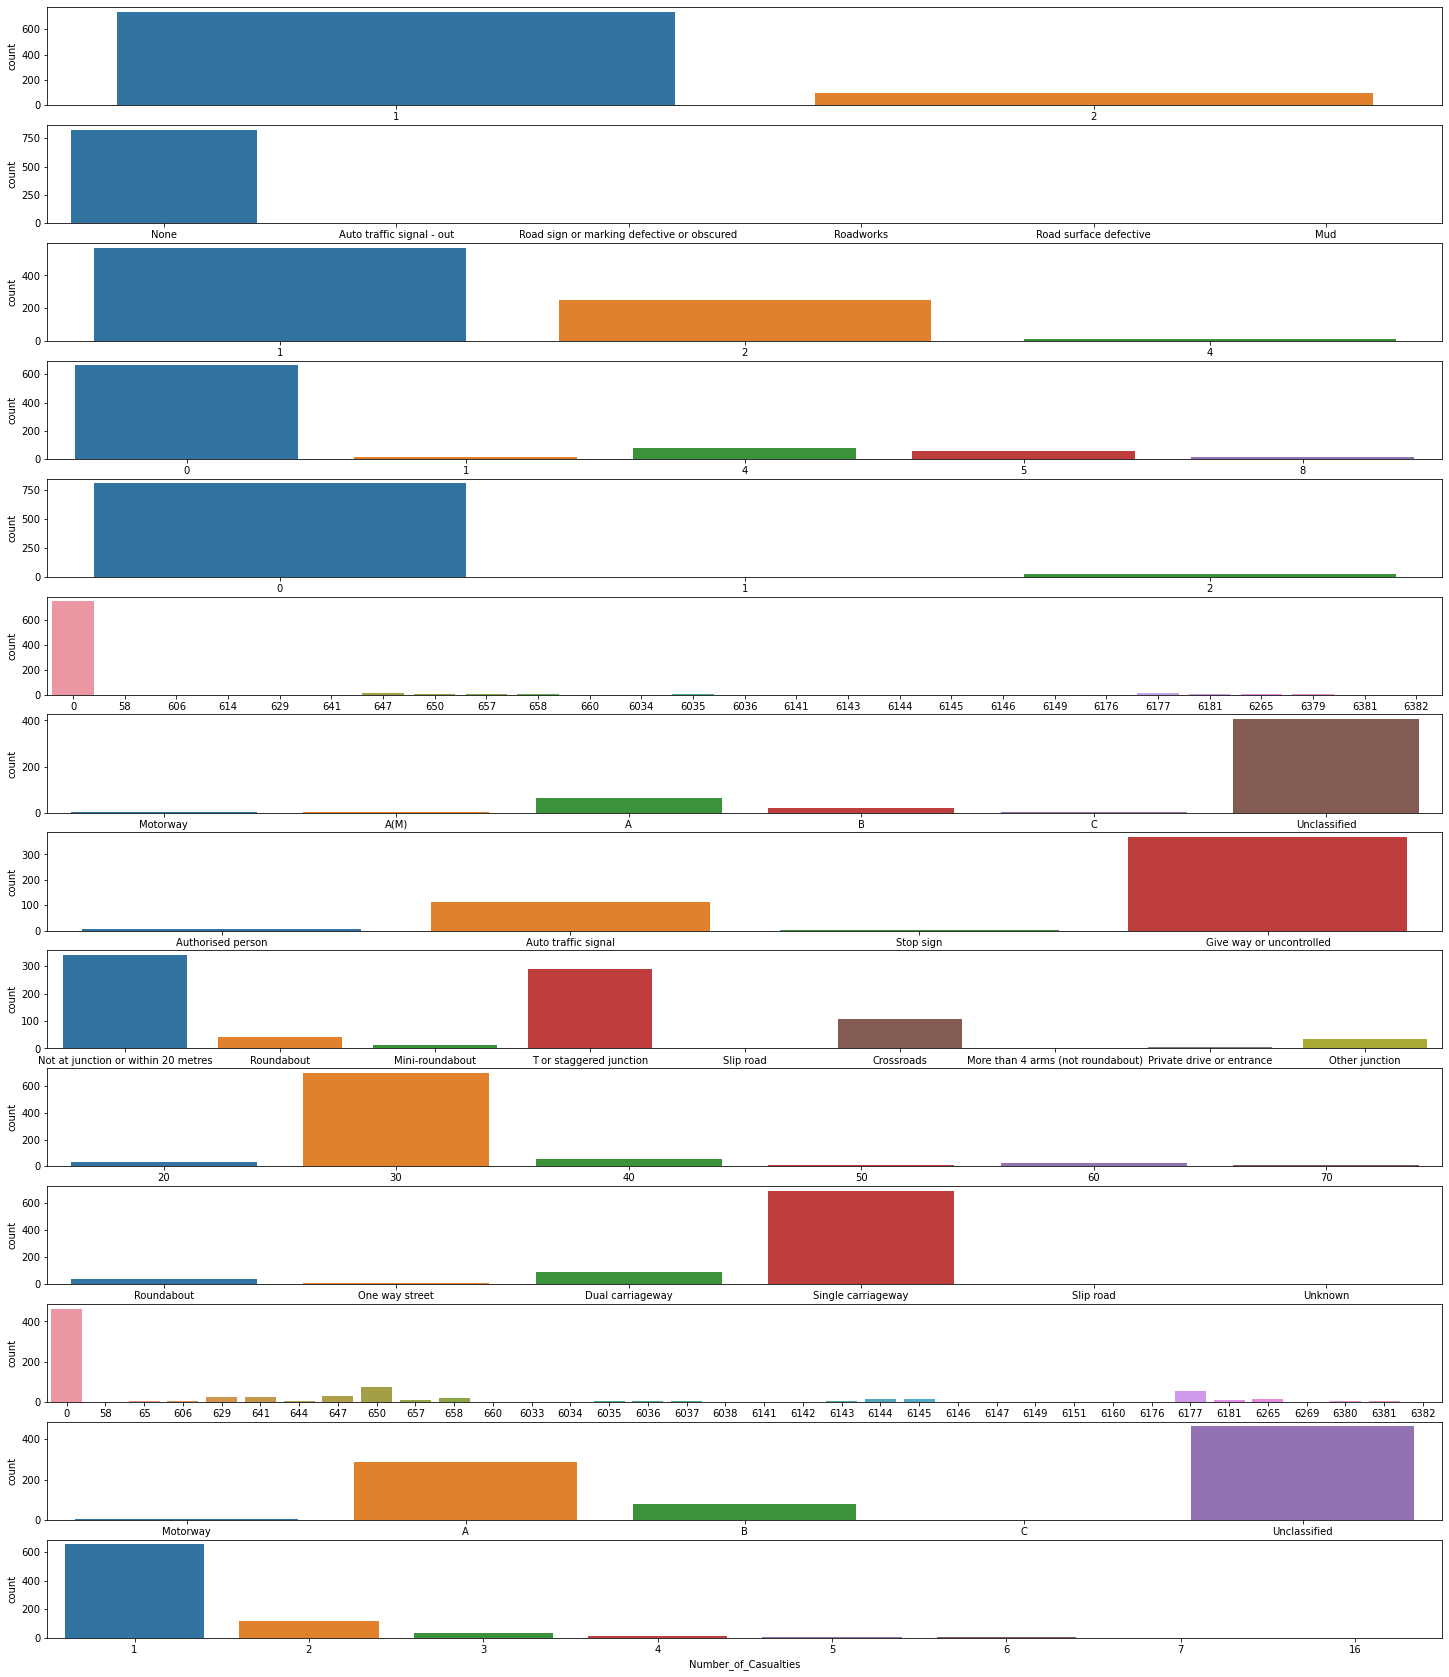

In [55]:
nfields_cat = len(rvl_fields_acci_cat)-1
figs, axs = plt.subplots(nrows=nfields_cat, ncols=1, figsize=(25, 30))

figrows = range(0, nfields_cat) #range(nfields_cat), range(nfields_cat)
col = 0

for row in figrows:
    print("nfields_cat",nfields_cat)
    field_x = rvl_fields_acci_cat[nfields_cat]

    # get the next categorical field in the list
    nfields_cat -= 1

    sns.countplot(x=field_x, data=DATA['accident'], ax=axs[row])


    try:
        axs[row].set_xlabel(field_x)
        x_ticks = get_unique_label_fld_lookup(data=DATA['accident'], colname=field_x)
        axs[row].set_xticklabels(x_ticks.label)

    except KeyError:
        axs[row].set_xlabel(field_x)


from this overview we see that many vaiables countain 0 count. we therefore contiueue with only var1 and var2

In [140]:
var1, var2

('Road_Type', 'Casualty_Severity')

# task 2

In [88]:
FLD_LOOKUP[var1]

,label
code,
1,Roundabout
2,One way street
3,Dual carriageway
6,Single carriageway
7,Slip road
9,Unknown


we see that code 0 should not be included in the data.  
lets make a mask that does that

In [89]:
maskp = DATA['casual'][var2] != 4329432989732478932789 # mask with no effect
#comparing how many we filter by using this mask
#print("Without pedestirans we have", len(DATA['casual'][var2]), "filtering on only pedsitraions we have", len(DATA['casual'][maskp][var2]), "records")

Without pedestirans we have 1117 filtering on only pedsitraions we have 1117 records


Making an contigency table for these 2 vars:

In [93]:
var1_labels

code
1            Roundabout
2        One way street
3      Dual carriageway
6    Single carriageway
7             Slip road
9               Unknown
Name: label, dtype: object

In [92]:
var2_labels

code
1      Fatal
2    Serious
3     Slight
Name: label, dtype: object

In [99]:
DATA['accident'][var1]
# 833 accidents

0      6
1      6
2      3
3      6
4      6
      ..
828    6
829    1
830    6
831    1
832    6
Name: Road_Type, Length: 833, dtype: int64

In [100]:
DATA['casual'][maskp][var2]
# 1117 hurt people (casualties)

0       3
1       3
2       3
3       3
4       3
       ..
1112    3
1113    3
1114    3
1115    3
1116    3
Name: Casualty_Severity, Length: 1117, dtype: int64

Every single casualty was part of an accident. So every single accident happended on a specific road type.  
We do an inner join to get the road_type column from accidents table

In [108]:
merged = DATA['casual'].merge(DATA['accident'], how="inner")
merged

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019136111019,2,1,1,1,56,9,3,0,0,...,0,0,4,1,1,0,0,1,1,E01010606
1,2019136111467,2,1,1,1,50,8,3,0,0,...,0,0,1,1,1,0,0,1,1,E01010618
2,2019136111467,2,2,2,2,46,8,3,0,0,...,0,0,1,1,1,0,0,1,1,E01010618
3,2019136121066,2,1,1,1,20,4,3,0,0,...,0,0,1,1,1,0,0,1,1,E01010615
4,2019136131015,1,1,1,2,52,8,3,0,0,...,0,5,1,1,1,0,0,1,1,E01010571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,2019136CT1224,1,1,2,1,30,6,3,0,0,...,0,0,4,1,1,0,0,1,1,E01010789
1113,2019136CT1457,1,1,1,1,34,6,3,0,0,...,0,0,4,1,1,0,0,1,1,E01010727
1114,2019136CU0568,1,1,3,2,8,2,3,5,1,...,0,0,1,1,1,0,0,1,1,E01010697
1115,2019136CU0969,2,1,1,2,23,5,3,0,0,...,0,0,1,1,2,0,0,1,2,E01010809


# Pearson test and plotting function

In [329]:
def get_pearson_test(observed):
    
    rowTotals = observed.sum(axis = 1) # R
    N = rowTotals.sum()
    
    chiVal, pVal, df, expected = chi2_contingency(observed)
    
    V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )

    return chiVal, pVal, df, observed, expected, V

def plot_pearson_test(observed, expected, title, var1_labels=None, var2_labels=None):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

    severity_labels = var2_labels
    #speed_categories = {20: "20 MPH", 30: "30 MPH", 40: "40 MPH", 50: "50 MPH", 60: "60 MPH", 70: "70 MPH"}
    
    x = np.array(list(var1_labels.keys()))

    for i, ax in enumerate(axes[0]):
        ax.plot(x, observed[:,i], 'ro-', label='Observed')
        ax.plot(x, expected[:,i], 'bo-', label='Expected')
        if i==0: 
            ax.set_ylabel('Casualties')
            ax.legend(loc='best');
        ax.set_title(severity_labels[i])
        ax.set_xticks(x)
        ax.set_xticklabels(list(var1_labels.values()))
        fig.autofmt_xdate(rotation=45)

    for i, ax in enumerate(axes[1]):
        ax.plot(x, observed[:,i]/expected[:,i], 'go-')
        ax.plot(x, np.ones(x.shape), 'k:')
            
        ax.plot(x, np.ones(x.shape)/2, 'm:', label='Significance level')
        
        if i==0: 
            ax.legend(loc='best');

        if i==0: 
            ax.set_ylabel('Observed/Expected')
        ax.set_xticks(x)
        ax.set_xticklabels(list(var1_labels.values()))
        fig.autofmt_xdate(rotation=45)
    
    fig.suptitle(title)
    

## Casualty_Severity vs Road_Type

In [390]:
#Compute a simple cross tabulation of two (or more) factors. computes a frequency table of the factors
observed_pd1 = pd.crosstab(merged["Road_Type"], merged["Casualty_Severity"], margins=False)
observed1 = observed_pd1.to_numpy()
observed_pd1

Casualty_Severity,1,2,3
Road_Type,,,
1,0,6,52
2,0,0,10
3,3,26,114
6,6,126,769
7,0,0,2
9,0,1,2


we do not want many zeros? so we remove the roadtype 7,9,2,1

In [391]:
# create mask
observed_pd1_mask = observed_pd1.sum(axis=1) >= 15
# use make to change data
observed_pd1_filtered = observed_pd1[observed_pd1_mask]
observed1 = observed_pd1_filtered.to_numpy()
observed_pd1_filtered


Casualty_Severity,1,2,3
Road_Type,,,
1,0,6,52
3,3,26,114
6,6,126,769


In [392]:
chiVal1, pVal1, df1, observed1, expected1, V1 = get_pearson_test(observed=observed1)
chiVal1, pVal1, df1, observed1, expected1.astype(int), V1

(6.423690349444632,
 0.16966246099353843,
 4,
 array([[  0,   6,  52],
        [  3,  26, 114],
        [  6, 126, 769]]),
 array([[  0,   8,  49],
        [  1,  20, 121],
        [  7, 129, 764]]),
 0.05398666548007271)

create labels

In [393]:
var1_labels1 = dict(get_unique_label_fld_lookup(data=merged, colname="Road_Type").label)
var2_labels1 = list(FLD_LOOKUP["Casualty_Severity"].label)
var1_labels1

{1: 'Roundabout',
 2: 'One way street',
 3: 'Dual carriageway',
 6: 'Single carriageway',
 7: 'Slip road',
 9: 'Unknown'}

In [394]:
labelcodestoremove1 = []
for labelcode in var1_labels1:
    if labelcode not in observed_pd1_filtered.index:
        labelcodestoremove1.append(labelcode)
        
for label in labelcodestoremove1:
    var1_labels1.pop(label)
var1_labels1

{1: 'Roundabout', 3: 'Dual carriageway', 6: 'Single carriageway'}

In [395]:
title1 = "Pearson test of independence: Casualty severity vs Road Type"

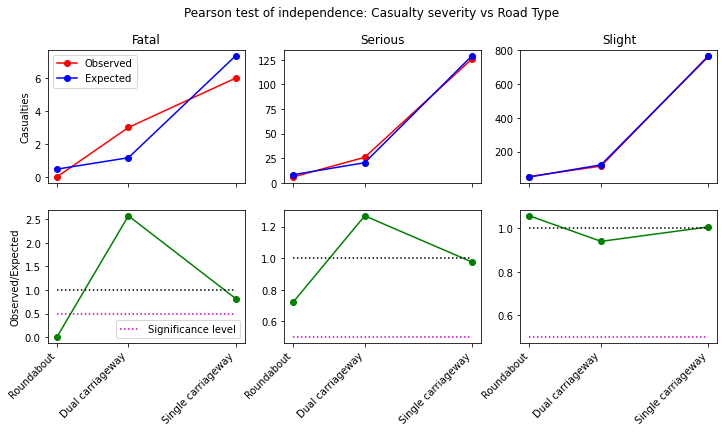

In [396]:
plot_pearson_test(observed=observed1, expected=expected1, var1_labels=var1_labels1, var2_labels=var2_labels1, title=title1)

But look at pVal1. way above 0.05!! pVal1=0.48. almost no association?  
Cramers V is 0.06, so overall the association is also not strong.

But look at single carriage way. very stronk. conclusion: there is a there's a strong correlation for road type 6 (single carrigeway - TODO: verify labels are correct)


In [237]:
var1

'Road_Type'

## Casualty_Severity vs Junction_Detail

In [343]:
observed_pd2 = pd.crosstab(merged["Junction_Detail"], merged["Casualty_Severity"], margins=False)
observed2 = observed_pd2.to_numpy()
observed_pd2

Casualty_Severity,1,2,3
Junction_Detail,,,
0,7,84,349
1,0,6,46
2,0,2,17
3,1,43,335
5,0,0,2
6,0,15,149
7,0,3,5
8,0,0,7
9,1,6,39


We remove the junction types with almost no accidents since we are not intersted in them, if there's no casualties happening.  
The Pearson chi-square test should only be used if most cells have an expected count above 5, and the minimum expected count is at least 1.  
Since we have 3 columns we say that we want the rows to sum to least $5*3 = 15$, so we obmit some rows

In [344]:
# create mask
observed_pd2_mask = observed_pd2.sum(axis=1) >= 15
# use make to change data
observed_pd2_filtered = observed_pd2[observed_pd2_mask]
observed2 = observed_pd2_filtered.to_numpy()
observed_pd2_filtered


Casualty_Severity,1,2,3
Junction_Detail,,,
0,7,84,349
1,0,6,46
2,0,2,17
3,1,43,335
6,0,15,149
9,1,6,39


In [375]:
var1_labels2 = dict(get_unique_label_fld_lookup(data=merged, colname="Junction_Detail").label)
var2_labels2 = list(FLD_LOOKUP["Casualty_Severity"].label)
var1_labels2

{0: 'Not at junction or within 20 metres',
 1: 'Roundabout',
 2: 'Mini-roundabout',
 3: 'T or staggered junction',
 5: 'Slip road',
 6: 'Crossroads',
 7: 'More than 4 arms (not roundabout)',
 8: 'Private drive or entrance',
 9: 'Other junction'}

we remove unnesesacrry labels

In [335]:
observed_pd2_filtered.index

Int64Index([0, 1, 2, 3, 6, 9], dtype='int64', name='Junction_Detail')

In [376]:
var1_labels2

{0: 'Not at junction or within 20 metres',
 1: 'Roundabout',
 2: 'Mini-roundabout',
 3: 'T or staggered junction',
 5: 'Slip road',
 6: 'Crossroads',
 7: 'More than 4 arms (not roundabout)',
 8: 'Private drive or entrance',
 9: 'Other junction'}

In [378]:
labelcodestoremove = []
for labelcode in var1_labels2:
    if labelcode not in observed_pd2_filtered.index:
        labelcodestoremove.append(labelcode)
        
for label in labelcodestoremove:
    var1_labels2.pop(label)
var1_labels2

{0: 'Not at junction or within 20 metres',
 1: 'Roundabout',
 2: 'Mini-roundabout',
 3: 'T or staggered junction',
 6: 'Crossroads',
 9: 'Other junction'}

In [338]:
chiVal2, pVal2, df2, observed2, expected2, V2 = get_pearson_test(observed=observed2)
chiVal2, pVal2, df2, observed2, expected2.astype(int), V2

(23.589755679636273,
 0.008767031306614794,
 10,
 array([[  7,  84, 349],
        [  0,   6,  46],
        [  0,   2,  17],
        [  1,  43, 335],
        [  0,  15, 149],
        [  1,   6,  39]]),
 array([[  3,  62, 374],
        [  0,   7,  44],
        [  0,   2,  16],
        [  3,  53, 322],
        [  1,  23, 139],
        [  0,   6,  39]]),
 0.10355006623859053)

In [383]:
title2 = "Pearson test of independence: Casualty severity vs Junction detail "

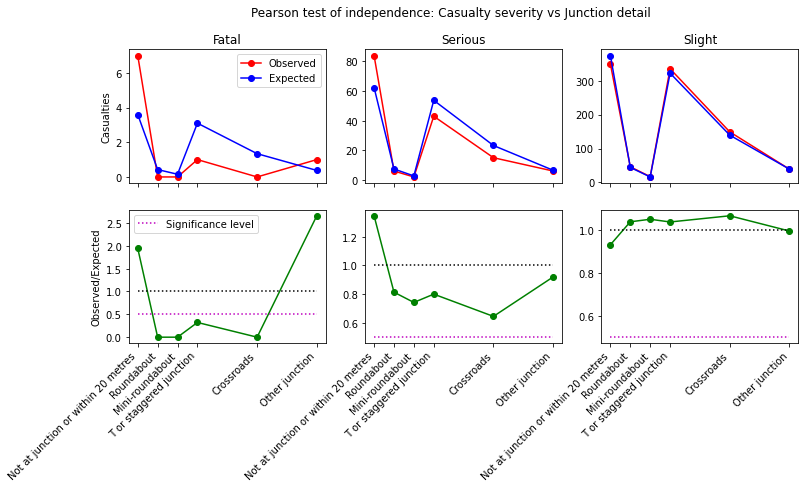

In [379]:
plot_pearson_test(observed=observed2, expected=expected2, var1_labels=var1_labels2, var2_labels=var2_labels2, title=title2)

## Casualty_Severity vs Speed_limit

Create labels

In [359]:
var1_labels3 = dict(get_unique_label_fld_lookup(data=merged, colname="Speed_limit").label)
var2_labels3 = list(FLD_LOOKUP["Casualty_Severity"].label)

var1_labels3

{20: '20 MPH',
 30: '30 MPH',
 40: '40 MPH',
 50: '50 MPH',
 60: '60 MPH',
 70: '70 MPH'}

Make contigency table

In [360]:
observed_pd3 = pd.crosstab(merged["Speed_limit"], merged["Casualty_Severity"], margins=False)
observed3 = observed_pd3.to_numpy()
observed_pd3

Casualty_Severity,1,2,3
Speed_limit,,,
20,0,11,26
30,5,126,812
40,4,11,55
50,0,3,8
60,0,4,36
70,0,4,12


We do the same for this contingency table and remove the 50 MPH row

In [361]:
# create mask
observed_pd3_mask = observed_pd3.sum(axis=1) >= 15
# use make to change data
observed_pd3_filtered = observed_pd3[observed_pd3_mask]
observed3 = observed_pd3_filtered.to_numpy()
observed_pd3_filtered


Casualty_Severity,1,2,3
Speed_limit,,,
20,0,11,26
30,5,126,812
40,4,11,55
60,0,4,36
70,0,4,12


Create speed limit labels by removing the 50

In [363]:
labelcodestoremove3 = []
for labelcode in var1_labels3:
    if labelcode not in observed_pd3_filtered.index:
        labelcodestoremove3.append(labelcode)
        
for label in labelcodestoremove3:
    var1_labels3.pop(label)
    
var1_labels3

{20: '20 MPH', 30: '30 MPH', 40: '40 MPH', 60: '60 MPH', 70: '70 MPH'}

In [364]:
chiVal3, pVal3, df3, observed3, expected3, V3 = get_pearson_test(observed=observed3)
chiVal3, pVal3, df3, observed3, expected3.astype(int), V3

(32.79764722539647,
 6.697856122280634e-05,
 8,
 array([[  0,  11,  26],
        [  5, 126, 812],
        [  4,  11,  55],
        [  0,   4,  36],
        [  0,   4,  12]]),
 array([[  0,   5,  31],
        [  7, 133, 802],
        [  0,   9,  59],
        [  0,   5,  34],
        [  0,   2,  13]]),
 0.12176676937324467)

In [365]:
title3 = "Pearson test of independence: Casualty severity vs Speed Limit"

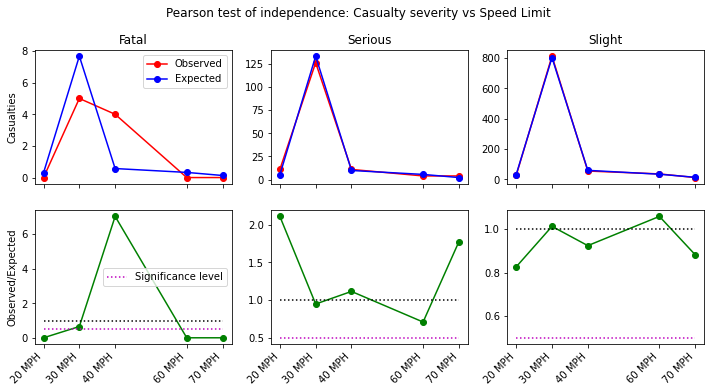

In [366]:
plot_pearson_test(observed=observed3, expected=expected3, var1_labels=var1_labels3, var2_labels=var2_labels3, title=title3)

## testing

/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Road_Type', ylabel='count'>

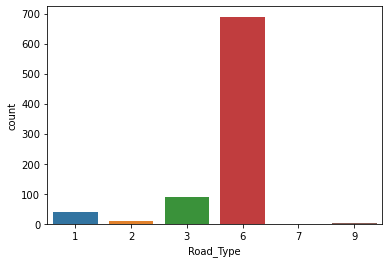

In [245]:
sns.countplot(DATA['accident'][var1])

In [246]:
chiVal, pVal, df, expected = chi2_contingency(observed)
chiVal, pVal, df, expected.astype(int)

(34.55477090638423,
 0.0001486948318451553,
 10,
 array([[  0,   5,  31],
        [  7, 134, 801],
        [  0,   9,  59],
        [  0,   1,   9],
        [  0,   5,  33],
        [  0,   2,  13]]))

In [247]:
V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
V

0.06218454041412297

/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Casualty_Severity', ylabel='count'>

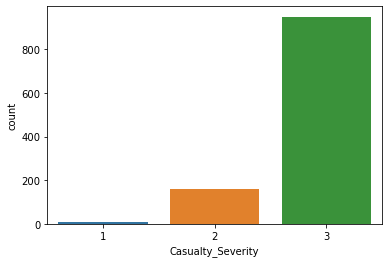

In [248]:
sns.countplot(DATA['casual'][var2])

/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Road_Type', ylabel='count'>

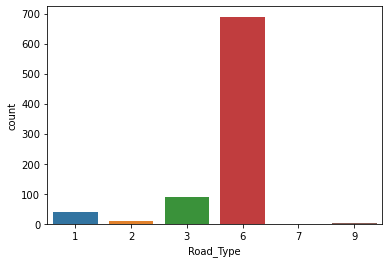

In [249]:
sns.countplot(DATA['accident'][var1])

/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Casualty_Severity', ylabel='count'>

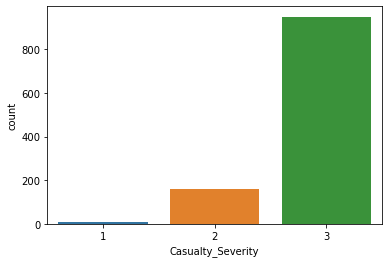

In [250]:
sns.countplot(DATA['casual'][var2])

/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Road_Type', ylabel='count'>

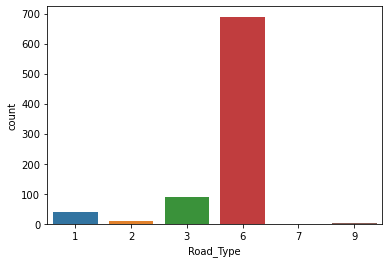

In [95]:
sns.countplot(DATA['accident'][var1])

/home/ts/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Casualty_Severity', ylabel='count'>

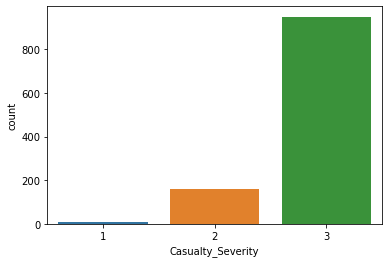

In [84]:
sns.countplot(DATA['casual'][var2])

In [ ]:
FLD_LOOKUP["Special_Conditions_at_Site"]

In [ ]:
DATA['casual']

In [ ]:
pd.unique(DATA['accident']["Special_Conditions_at_Site"])

In [ ]:
get_unique_label_var_lookup(dataset=DATA['accident'], colname="Special_Conditions_at_Site")

<hr>

# Lecture 4: Spatial filtering

## Filtering with external table

Let's select all rows for the city name:

We want to use this list of LSOA11 codes to restrict our accident data set.

Filter

Export

## Spatial filtering with shapely

Jupyter visualizes shapely objects!

Let's get all accident coordinates (from the whole UK)

`contains()` and `within()` check for point inclusion:

Limit vehicles and casualties to these AccidentIndices

What does it mean?  
See: https://www.computerhope.com/unix/udiff.htm

<hr>

# Lecture 5: Visualizing spatial data

Inspired by: https://alysivji.github.io/getting-started-with-folium.html

The heatmap is built with KDE:  
https://en.wikipedia.org/wiki/Kernel_density_estimation

We can also add automatic clusters: